# Impor Libraries

In [2]:
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import plot_roc_curve, cal_acc_pres_f1
from modules.graph import Graph
import os

/home/vale/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.3.0+cu121


In [3]:
#FIXME: el edge (1,2) es equivalente a (2,1)), es importante asegurarse de que ambos casos se asignen al mismo conjunto (entrenamiento, validación o prueba). La implementación actual, sin embargo, no garantiza esto.
#FIXME: Entrenamiento con unicamente nodos, areglar varanza (long tail) y normalizar 
#FIXME: porq me esta dando la validacion eso, ver ambos lados como se infieren???

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : DotProduct
    

In [4]:
# CASO 1 ----------------------------------------------------------------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[SAVE : /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraph/edges.csv]
DiGraph with 74145 nodes and 461889 edges
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


In [5]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset(0.2)
# gnn.split_dtaset_v2()



gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])
  train_error.append(loss.item())

  # Calcular la pérdida en el conjunto de validación
  val_loss = F.binary_cross_entropy_with_logits(scores[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)


  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}, train acc: {}, val acc: {}'.format(e, loss,train_acc,val_acc))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

# Graficar la precisión en el conjunto de entrenamiento y validación
plt.figure()
plt.plot(acc_train, label='Entrenamiento')
plt.plot(acc_val, label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

# Graficar Error en el conjunto de entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(model_complexity, train_error, label='Training Sample', color='cyan', linewidth=2)
plt.plot(model_complexity, val_error, label='Test Sample', color='red', linewidth=2)
plt.xlabel('Model Complexity')
plt.ylabel('Prediction Error')
plt.title('Overfitting')
plt.legend()
plt.grid(True)
plt.show()


Done saving data into cached files.
None


TypeError: GNN.split_dataset() takes 1 positional argument but 2 were given

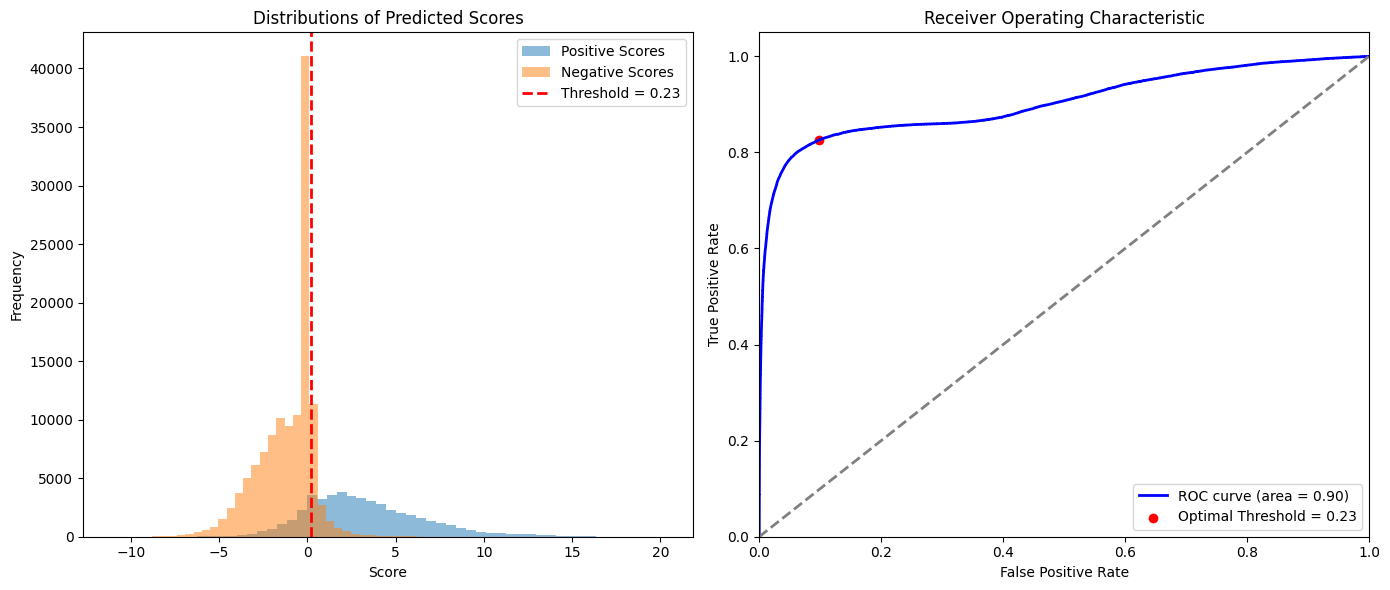

AUC: 0.9032034891053821
CALCULO
IF
ACCURACY 0.88106311525545
PRESICION 0.7625753361149745
RECALL 0.8259132181262815
F1 SCORE 0.7929815398830928
Classification Report:

              precision    recall  f1-score   support

           0     0.9315    0.9021    0.9166    125504
           1     0.7626    0.8259    0.7930     47798

    accuracy                         0.8811    173302
   macro avg     0.8471    0.8640    0.8548    173302
weighted avg     0.8849    0.8811    0.8825    173302



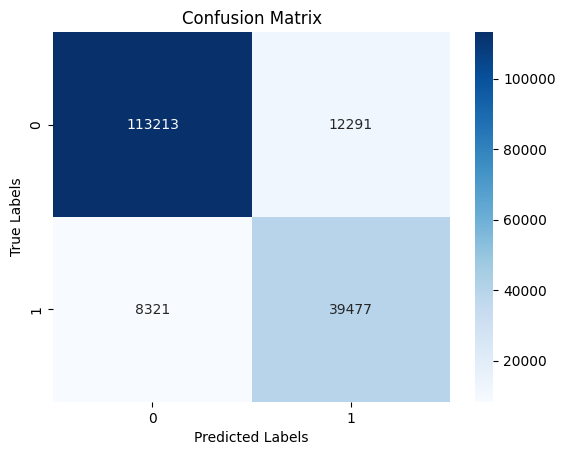

In [ ]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 2: 
    * Model :GraphSAGE
    * Features : ALL
    * Predictor : MLPPredictor
    

Done loading data from cached files.
None
Training edges: 260095
Validation edges: 86963
Test edges: 86921
In epoch 0, loss: 0.8579565286636353
In epoch 10, loss: 0.5113863348960876
In epoch 20, loss: 0.3404759168624878
In epoch 30, loss: 0.2426937371492386
In epoch 40, loss: 0.1902439445257187
In epoch 50, loss: 0.16825062036514282
In epoch 60, loss: 0.15279333293437958
In epoch 70, loss: 0.14264197647571564


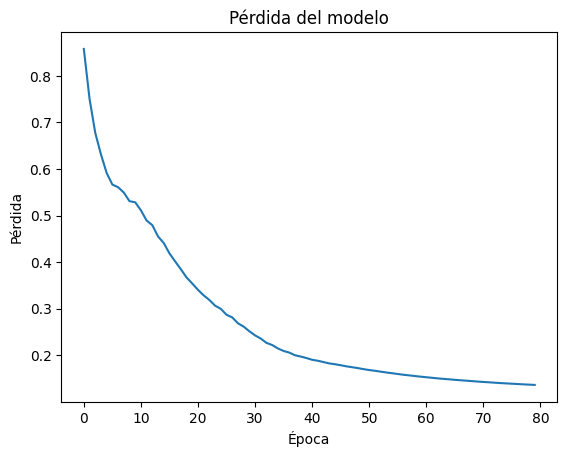

In [6]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()



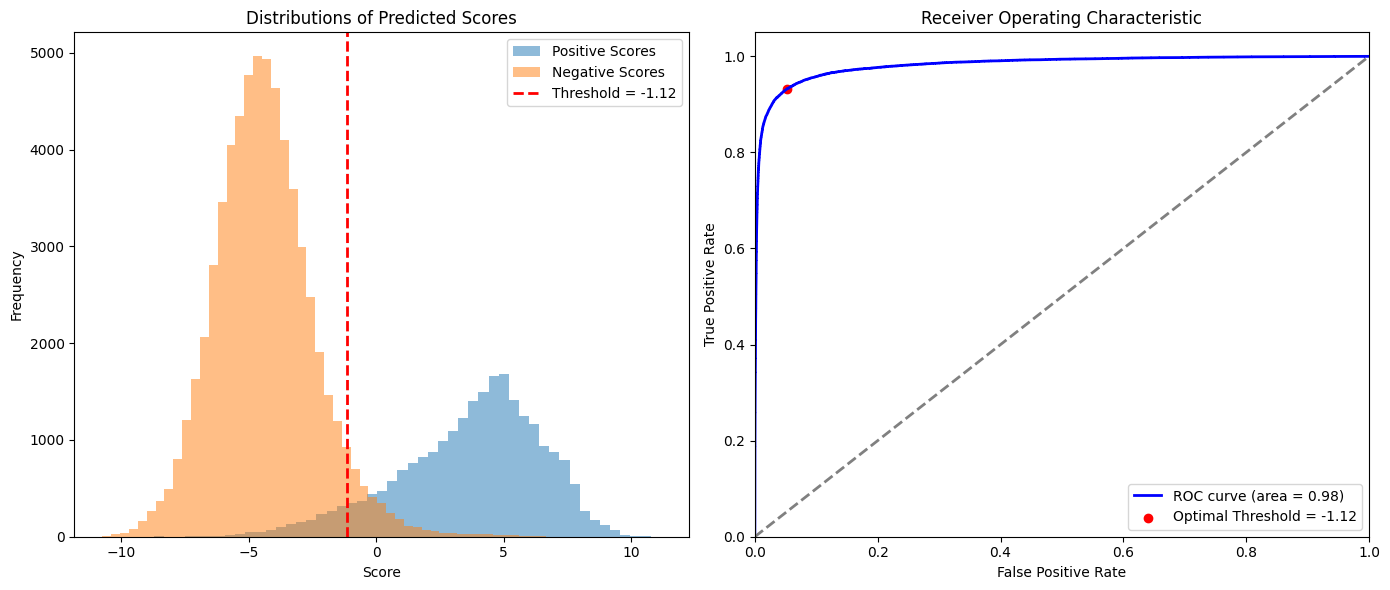

AUC: 0.9820875388990122
CALCULO
IF
ACCURACY 0.9432933353274813
PRESICION 0.872147533997133
RECALL 0.9325186412593206
F1 SCORE 0.9013232968308943
Classification Report:

              precision    recall  f1-score   support

           0     0.9733    0.9474    0.9602     62781
           1     0.8721    0.9325    0.9013     24140

    accuracy                         0.9433     86921
   macro avg     0.9227    0.9400    0.9308     86921
weighted avg     0.9452    0.9433    0.9439     86921



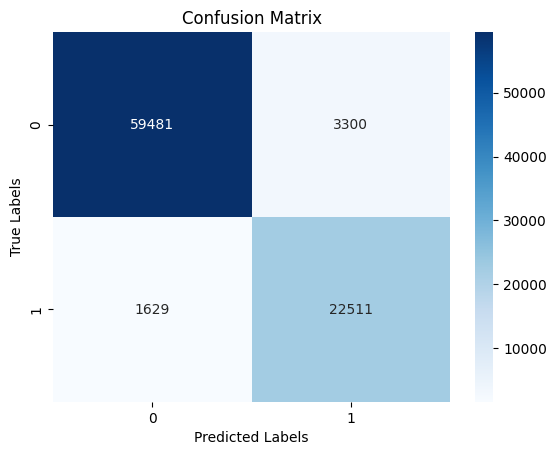

In [7]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 3: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : DotPredictor
    

In [8]:
# Crear dataset
""" node_id,feat
 1,"10, 7"
 7843,"33, 54"

 """
import os
from modules.graph import Graph

path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[SAVE : /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/edges.csv]
DiGraph with 74145 nodes and 461889 edges
[SAVE IN: /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/nodes.csv]
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 260893
Validation edges: 86608
Test edges: 86478
tensor([[10.,  7.],
        [15.,  3.],
        [21.,  2.],
        ...,
        [ 2.,  0.],
        [ 2., 12.],
        [ 1.,  0.]])
In epoch 0, loss: 7387777.0
In epoch 10, loss: 264640.375
In epoch 20, loss: 413823.09375
In epoch 30, loss: 162022.796875
In epoch 40, loss: 74613.0078125
In epoch 50, loss: 53004.3984375
In epoch 60, loss: 34373.32421875
In epoch 70, loss: 22667.892578125
In epoch 80, loss: 17664.564453125
In epoch 90, loss: 14714.6552734375
In epoch 100, loss: 12291.5419921875
In epoch 110, loss: 10903.0673828125
In epoch 120, loss: 10061.708984375
In epoch 130, loss: 9340.041015625
In epoch 140, loss: 8579.8916015625
In epoch 150, loss: 7904.99462890625
In epoch 160, loss: 7347.748046875
In epoch 170, loss: 6686.19970703125
In epoch 180, loss: 6131.55859375
In epoch 190, loss: 5606.78466796875


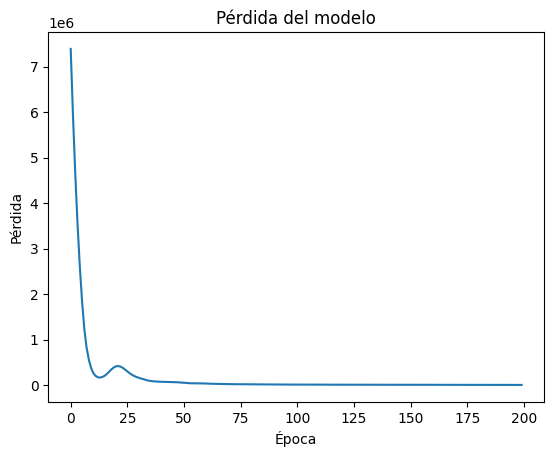

In [9]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
print(gnn.dgl_graph.ndata['feat'] )

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(200):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()



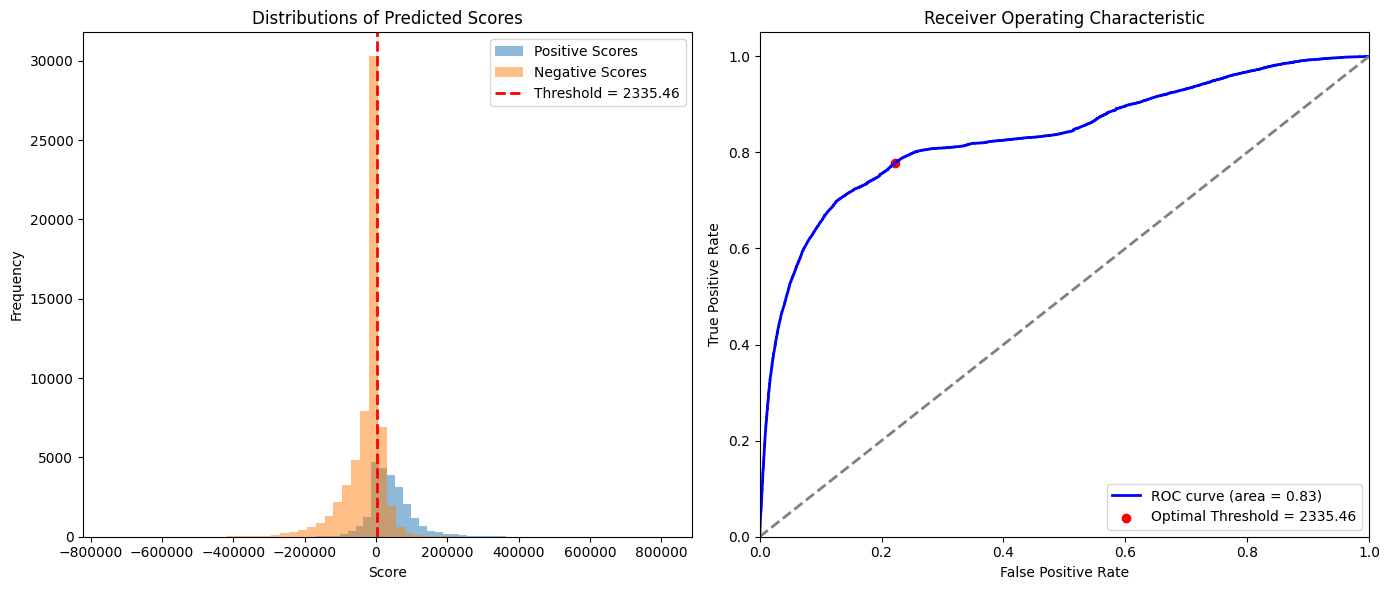

AUC: 0.8345524511778856
CALCULO
IF
ACCURACY 0.7781747959018479
PRESICION 0.5733115703242894
RECALL 0.7774807885065153
F1 SCORE 0.6599663210139147
Classification Report:

              precision    recall  f1-score   support

           0     0.9013    0.7784    0.8354     62534
           1     0.5733    0.7775    0.6600     23944

    accuracy                         0.7782     86478
   macro avg     0.7373    0.7780    0.7477     86478
weighted avg     0.8105    0.7782    0.7868     86478



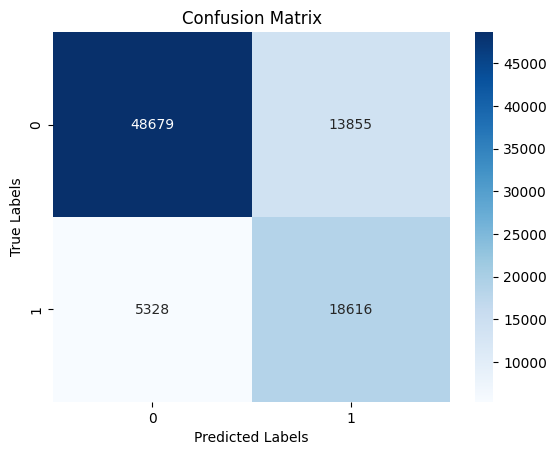

In [10]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 4: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [11]:
from modules.graph import *

LIST_FEATURES_NO_CATEG = ['AS_rank_numberAsns', 'AS_rank_customer', 'peeringDB_fac_count', 'cti_top']

LIST_FEATURES_CATEG = ['AS_rank_continent',
                        # 'peeringDB_info_ratio',
                        # 'peeringDB_info_scope',
                        # 'peeringDB_info_type',
                        # 'peeringDB_policy_general'
                        'ASDB_C1L1'
                        ]

# Crear Di graph 
list_feat = LIST_FEATURES_NO_CATEG + LIST_FEATURES_CATEG
path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[SAVE : /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraph/edges.csv]
DiGraph with 74145 nodes and 461889 edges
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


In [12]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

val_values = []
train_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  train_values.append(scores[train_mask])
  val_values.append(scores[gnn.val_mask])
  



  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))

print(train_values)

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


# # Graficar Error en el conjunto de entrenamiento y validación
# plt.figure(figsize=(8, 6))
# plt.plot(model_complexity, train_error, label='Training Sample', color='cyan', linewidth=2)
# plt.plot(model_complexity, val_error, label='Test Sample', color='red', linewidth=2)
# plt.xlabel('Model Complexity')
# plt.ylabel('Prediction Error')
# plt.title('Overfitting')
# plt.legend()
# plt.grid(True)
# plt.show()


Done loading data from cached files.
None


TypeError: GNN.split_dataset() takes 1 positional argument but 2 were given

In [22]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

ValueError: Found input variables with inconsistent numbers of samples: [174062, 86457]

In [ ]:
predicted_scores = (predicted_scores > threshold).astype(int)



# Caso 5:
    * Model : ???
    * Features : ???
    * Predictor : ???
Se crea un grafo a partir de un collector de RIPE NCC y ver si este generaliza para otro grafos

In [ ]:
# Descargar grafo de BGPStream
#DEMORA HARTO
# from datasets.ROUTE_COLLECTORS.downloads import *
# dgl_graph_loaded, nx_graph = download_graph_from_bgpstream("2022-07-01 00:00:00", "2022-07-01 00:15:00", ["rrc00"], "ribs")


In [10]:
# Etiquetar grafo con CAIDA AS Relationships 
# Cargar el grafo desde el archivo .dgl
import os
import dgl
import networkx as nx
path = os.getcwd() + "/datasets/ROUTE_COLLECTORS/AS_GRAPH_NO_DIRIGIDO.dgl"
graphs, _ = dgl.load_graphs(path)
print(graphs)


[Graph(num_nodes=79957, num_edges=441580,
      ndata_schemes={}
      edata_schemes={})]


In [8]:
!ls datasets/ROUTE_COLLECTORS/Downloads/graph-2022-06-rrc00-ribs-edges.csv

graph-2022-06-rrc00-ribs-edges.csv


In [15]:

path = "datasets/ROUTE_COLLECTORS/Downloads/graph-2022-06-rrc00-ribs-edges.csv"
print(path)
g = nx.read_edgelist(path, delimiter=',', nodetype=int, comments='src_id,dst_id')


# Agregar atributos para cada AS

datasets/ROUTE_COLLECTORS/Downloads/graph-2022-06-rrc00-ribs-edges.csv


TypeError: Failed to convert nodes 30372,{40179} to type <class 'int'>.

In [ ]:
# Importar grafo de entrenamiento